# Logistic regression

In this notebook, heavily inspired by [PyMC3's Logistic Regression examples](https://docs.pymc.io/en/stable/pymc-examples/examples/generalized_linear_models/GLM-logistic.html) we model the probability of one making more thean $50,000 using the [Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult). We use `aeppl` as a modeling language and `aehmc`'s NUTS algorithm to sample from the posterior distribution.

In [28]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

import aesara
import aesara.tensor as at
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesOpt, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
import aehmc.nuts as nuts
from aehmc.utils import RaveledParamsMap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
NUM_SAMPLES = 1_000
BURNIN = 100

## Load an prepare the data

In [30]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [31]:
income = 1 * (raw_data['income'] == " >50K")

data = raw_data[["age", "educ", "hours"]]
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

Y_val = income.values
X_val = data[["age", "age2","educ", "hours"]].values

/tmp/ipykernel_9734/2346469929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age"] = data["age"] / 10.0
/tmp/ipykernel_9734/2346469929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age2"] = np.square(data["age"])
/tmp/ipykernel_9734/2346469929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [32]:
data.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

### PyMC3 model implementation

In [26]:
with pm.Model() as pymc3_model:
    intercept = pm.Normal('intercept', 0, 1)
    age = pm.Normal('age', 0, 1)
    age2 = pm.Normal('age2', 0, 1)
    educ = pm.Normal('educ', 0, 1)
    hours = pm.Normal('hours', 0, 1)
    theta = pm.math.sigmoid(intercept + age * data['age'] + age2 * data['age2'] + educ * data['educ'] + hours * data['hours'])
    y = pm.Bernoulli('y', theta, observed=data['income'])


    #pm.glm.GLM.from_formula(
    #    "income ~ age + age2 + educ + hours", data, family=pm.glm.families.Binomial()
    #)
    step = pm.step_methods.NUTS([intercept, age, age2, educ, hours])
    trace = pm.sample(NUM_SAMPLES, tune=1000, step=step, init="adapt_diag", chains=1)

/tmp/ipykernel_9734/1650273198.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000, step=step, init="adapt_diag", chains=1)
Sequential sampling (1 chains in 1 job)
NUTS: [hours, educ, age2, age, intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 320 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Got error No model on context stack. trying to find log_likelihood in translation.
/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'age2'}>,
        <AxesSubplot:title={'center':'age2'}>],
       [<AxesSubplot:title={'center':'educ'}>,
        <AxesSubplot:title={'center':'educ'}>],
       [<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'hours'}>]], dtype=object)

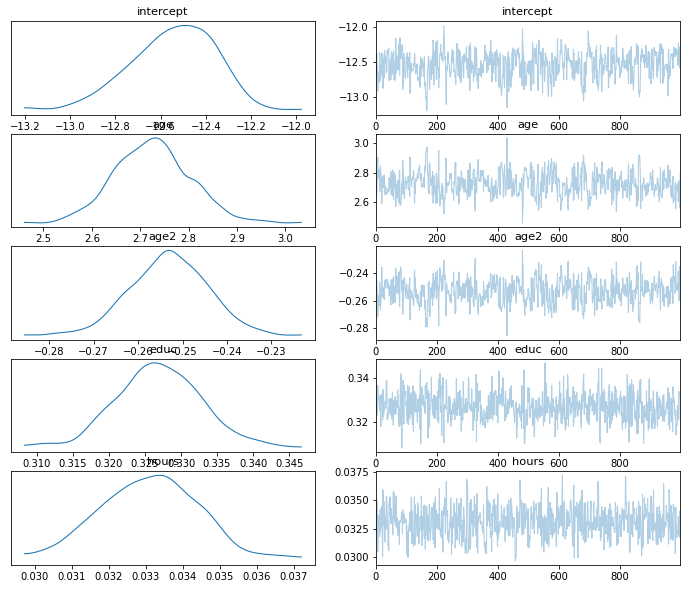

In [33]:
az.plot_trace(trace)

In [34]:
trace.get_sampler_stats('step_size_bar')

array([0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146, 0.0540146,
       0.0540146, 0.0540146, 0.0540146, 0.0540146, 

In [35]:
pymc3_covariance = step.potential._var
pymc3_covariance

array([1.74023394e-06, 5.35299656e-05, 8.58499716e-05, 6.89460338e-03,
       4.48850485e-02])

### Aeppl model implementation

In [36]:
X_at = at.as_tensor(X_val)
Y_at = at.as_tensor(Y_val)

A_rv = at.random.normal(0, 1, name='alpha')
B_rv = at.random.normal(0, 1, size=(4,), name='beta')
P_rv = at.sigmoid(A_rv + at.dot(X_at, B_rv))
Y_rv = at.random.bernoulli(P_rv)

rp_map = RaveledParamsMap((A_rv, B_rv))

def logistic_logprob(q):
    unraveled_params = rp_map.unravel_params(q)
    A_vv = unraveled_params[A_rv]
    B_vv = unraveled_params[B_rv]
    logprob = joint_logprob({Y_rv: Y_at, A_rv: A_vv, B_rv: B_vv})
    return logprob

### Sampling with aehmc's NUTS algorithm

In [37]:
STEP_SIZE = 8e-4

srng = RandomStream(seed=0)
inverse_mass_matrix = at.as_tensor([1., 1., 1., 1., 1.])
kernel = nuts.kernel(srng, logistic_logprob, inverse_mass_matrix)

q = at.vector('q')
potential_energy = -logistic_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad, STEP_SIZE)
kernel_fn = aesara.function((q,), next_step[0])
print(kernel_fn(np.array([-5., 0.1, 0, 0.33, 0.034])))

WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  Fil

[array([-5.   ,  0.1  ,  0.   ,  0.33 ,  0.034]), array(21363.36960153), array([  9031.14275897,  32250.72978897, 131405.86021611,  94528.54995442,
       370658.53949449]), array(True), array(False)]


We now compare the logprob values given by `aeppl` and `pyMC3`

In [40]:
q = at.vector('q')
logprob_fn = aesara.function((q,), logistic_logprob(q))
logprob_fn(np.array([-5., 0, 0, 0.25, 0.02]))

array(-16068.84972601)

In [41]:
pymc3_model.logp({'intercept': -5., 'age': 0, 'age2': 0, 'educ': 0.25, 'hours': 0.02})

array(-16068.84972601)

The difference probably stems from the use of a flat prior on the intercept.

In [42]:
q = at.vector("q")
potential_energy = -logprob_fn(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

step_size = at.scalar("step_size")
inverse_mass_matrix = at.vector("inverse_mass_matrix")
num_integration_steps = at.scalar("num_integration_steps", dtype="int32")

kernel = nuts.kernel(srng, logprob_fn, inverse_mass_matrix)

trajectory, updates = aesara.scan(
    fn=kernel,
    outputs_info=[
        {"initial": q},
        {"initial": potential_energy},
        {"initial": potential_energy_grad},
        None,
        None
    ],
    non_sequences=step_size,
    n_steps=num_samples,
)
trajectory_generator = aesara.function(
    (q, step_size, inverse_mass_matrix),
    trajectory,
    updates=updates,
    mode='FAST_RUN'
)

In [43]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, logistic_logprob, num_samples=1_000
)

initial_position = np.array([-5., 0., 0, 0.25, 0.02])
inverse_mass_matrix = pymc3_covariance
print(inverse_mass_matrix)
position, *_ = trajectory_generator(initial_position, 10e-4, inverse_mass_matrix)

WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  Fil

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (Shape_i{0}.0,), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 866, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2855, in get_vector_length
    raise ValueError(f"Le

[1.74023394e-06 5.35299656e-05 8.58499716e-05 6.89460338e-03
 4.48850485e-02]
CPU times: user 1min 47s, sys: 1.12 s, total: 1min 48s
Wall time: 1min 48s


In [44]:
position

array([[-4.99999785e+00,  1.10601445e-06,  8.88137536e-06,
         2.50353451e-01,  2.81635098e-02],
       [-5.00000424e+00, -1.29991530e-05,  1.31833869e-05,
         2.50600201e-01,  3.18875739e-02],
       [-5.00000413e+00, -7.98730833e-06,  3.92716888e-06,
         2.49989016e-01,  2.91100242e-02],
       ...,
       [-4.99994792e+00,  2.20668418e-03,  1.77642262e-02,
         2.39850863e-01,  2.59555022e-02],
       [-4.99994622e+00,  2.24885078e-03,  1.78208677e-02,
         2.39534108e-01,  2.56986353e-02],
       [-4.99994778e+00,  2.25789513e-03,  1.78673083e-02,
         2.40021147e-01,  2.57200826e-02]])

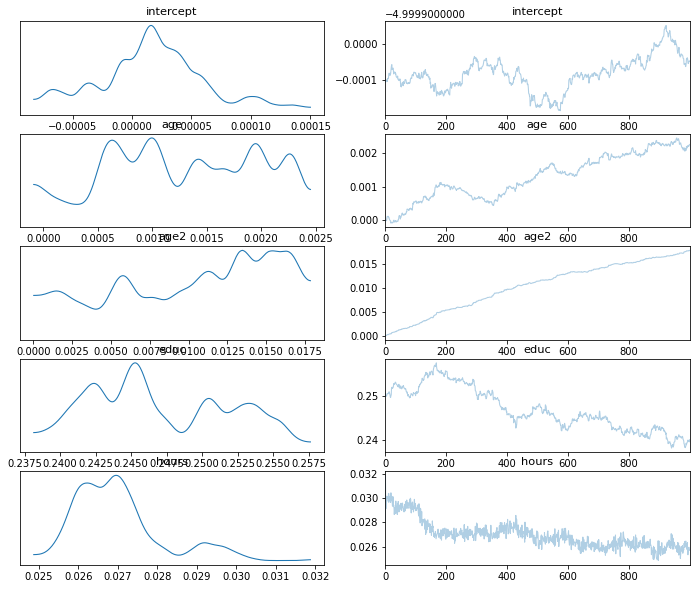

In [45]:
import arviz as az

BURNIN = 0
aehmc_trace = az.from_dict(
    posterior={
        "intercept": position[BURNIN:, 0],
        "age": position[BURNIN:, 1],
        "age2": position[BURNIN:, 2],
        "educ": position[BURNIN:, 3],
        "hours": position[BURNIN:, 4],
    }
)
az.plot_trace(aehmc_trace);